In [7]:
#importaciones de las librerias
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as pl
import mlxtend as mx
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

In [8]:
data=pd.read_csv("coches.csv")#Leemos el fichero csv
data

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


In [9]:
print(data.groupby('gender').size())

gender
0    469
1    494
dtype: int64


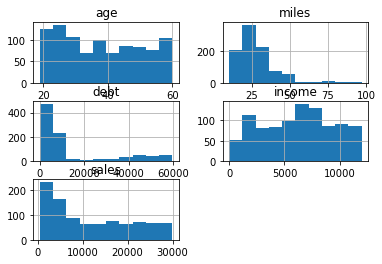

In [10]:
data.drop(['gender'],axis=1).hist()
pl.show()

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

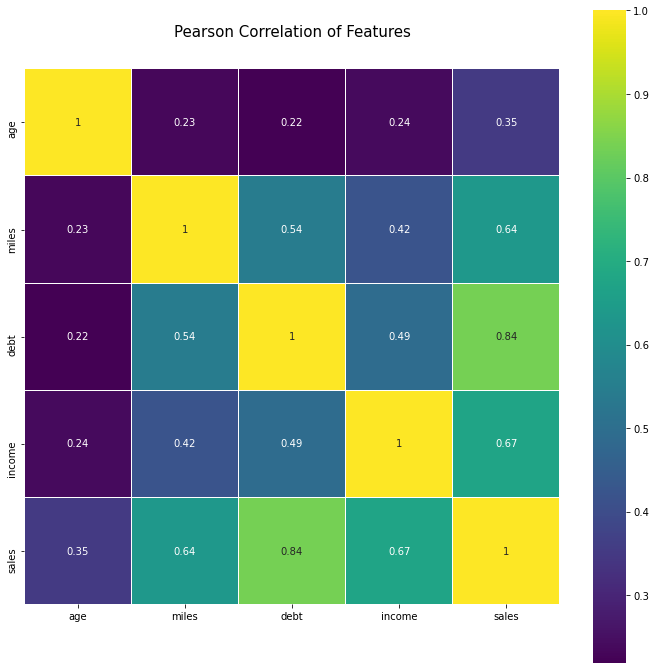

In [11]:
X=data.drop(['gender'], axis=1)
y=data['gender']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)


used_features =X.columns[selected]
 
colormap = pl.cm.viridis
pl.figure(figsize=(12,12))
pl.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(data[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=6) 
y_train =X_train["gender"]
y_test = X_test["gender"]

In [14]:
# Instantiate the classifier

gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])
 
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Precisión en el set de Entrenamiento: 0.52
Precisión en el set de Test: 0.55


In [16]:
print(gnb.predict([[25,12,5000,5000,5000],[35,20,5000,5000,5000]]))

[1 1]
